<a href="https://colab.research.google.com/github/troveski/Tracking-/blob/main/Blink.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Copyright 2020 DeepMind Technologies Limited.

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

<p align="center">
  <h1 align="center">Blink: The blink is a Boundary Locator for Identified Nodes</h1>
  <p align="center">
    <a href="https://www.linkedin.com/in/%C3%A1lvaropatricio/">Álvaro Patrício</a>
    
    
  </p>
  <h3 align="center"><a href="https://arxiv.org/abs/2306.08637">Paper</a> | <a href="https://deepmind-tapir.github.io">Project Page</a> | <a href="https://github.com/deepmind/tapnet">GitHub</a> | <a href="https://github.com/deepmind/tapnet/tree/main#running-tapir-locally">Live Demo</a> </h3>
  <div align="center"></div>
</p>

<p align="center">
  <a href="">
    <img src="https://storage.googleapis.com/dm-tapnet/swaying_gif.gif" alt="Logo" width="50%">
  </a>
</p>

In [22]:
# @title Download Code {form-width: "25%"}
!git clone https://github.com/deepmind/tapnet.git

fatal: destination path 'tapnet' already exists and is not an empty directory.


In [23]:
# @title Install Dependencies {form-width: "25%"}
!pip install -r tapnet/requirements_inference.txt

In [24]:
# @title Download Model {form-width: "25%"}

%mkdir tapnet/checkpoints

!wget -P tapnet/checkpoints https://storage.googleapis.com/dm-tapnet/causal_tapir_checkpoint.npy

%ls tapnet/checkpoints

mkdir: cannot create directory ‘tapnet/checkpoints’: File exists
--2023-12-25 23:52:20--  https://storage.googleapis.com/dm-tapnet/causal_tapir_checkpoint.npy
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.172.207, 108.177.112.207, 74.125.124.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.172.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 127043639 (121M) [application/octet-stream]
Saving to: ‘tapnet/checkpoints/causal_tapir_checkpoint.npy.1’

causal_tapir_checkp 100%[===================>] 121.16M  88.1MB/s    in 1.4s    

2023-12-25 23:52:22 (88.1 MB/s) - ‘tapnet/checkpoints/causal_tapir_checkpoint.npy.1’ saved [127043639/127043639]

causal_tapir_checkpoint.npy  causal_tapir_checkpoint.npy.1


In [25]:
# @title Imports {form-width: "25%"}
%matplotlib widget
import functools

import haiku as hk
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import mediapy as media
import numpy as np
from tqdm import tqdm
import tree

from tapnet import tapir_model
from tapnet.utils import transforms
from tapnet.utils import viz_utils

from google.colab import output
output.enable_custom_widget_manager()

#new imports

import cv2  # For reading the image
from google.colab.patches import cv2_imshow  # Import cv2_imshow function for Colab


In [26]:
# @title Load Checkpoint {form-width: "25%"}

checkpoint_path = 'tapnet/checkpoints/causal_tapir_checkpoint.npy'
ckpt_state = np.load(checkpoint_path, allow_pickle=True).item()
params, state = ckpt_state['params'], ckpt_state['state']

In [27]:
# @title Build Model {form-width: "25%"}

# Internally, the tapir model has three stages of processing: computing
# image features (get_feature_grids), extracting features for each query point
# (get_query_features), and estimating trajectories given query features and
# the feature grids where we want to track (estimate_trajectories).  For
# tracking online, we need extract query features on the first frame only, and
# then call estimate_trajectories on one frame at a time.

def build_online_model_init(frames, query_points):
  """Initialize query features for the query points."""
  model = tapir_model.TAPIR(use_causal_conv=True, bilinear_interp_with_depthwise_conv=False)

  feature_grids = model.get_feature_grids(frames, is_training=False)
  query_features = model.get_query_features(
      frames,
      is_training=False,
      query_points=query_points,
      feature_grids=feature_grids,
  )
  return query_features


def build_online_model_predict(frames, query_features, causal_context):
  """Compute point tracks and occlusions given frames and query points."""
  model = tapir_model.TAPIR(use_causal_conv=True, bilinear_interp_with_depthwise_conv=False)
  feature_grids = model.get_feature_grids(frames, is_training=False)
  trajectories = model.estimate_trajectories(
      frames.shape[-3:-1],
      is_training=False,
      feature_grids=feature_grids,
      query_features=query_features,
      query_points_in_video=None,
      query_chunk_size=64,
      causal_context=causal_context,
      get_causal_context=True,
  )
  causal_context = trajectories['causal_context']
  del trajectories['causal_context']
  return {k: v[-1] for k, v in trajectories.items()}, causal_context


online_init = hk.transform_with_state(build_online_model_init)
online_init_apply = jax.jit(online_init.apply)

online_predict = hk.transform_with_state(build_online_model_predict)
online_predict_apply = jax.jit(online_predict.apply)

rng = jax.random.PRNGKey(42)
online_init_apply = functools.partial(
    online_init_apply, params=params, state=state, rng=rng
)
online_predict_apply = functools.partial(
    online_predict_apply, params=params, state=state, rng=rng
)

In [28]:
# @title Utility Functions {form-width: "25%"}

def preprocess_frames(frames):
  """Preprocess frames to model inputs.

  Args:
    frames: [num_frames, height, width, 3], [0, 255], np.uint8

  Returns:
    frames: [num_frames, height, width, 3], [-1, 1], np.float32
  """
  frames = frames.astype(np.float32)
  frames = frames / 255 * 2 - 1
  return frames


def postprocess_occlusions(occlusions, expected_dist):
  """Postprocess occlusions to boolean visible flag.

  Args:
    occlusions: [num_points, num_frames], [-inf, inf], np.float32

  Returns:
    visibles: [num_points, num_frames], bool
  """
  pred_occ = jax.nn.sigmoid(occlusions)
  pred_occ = 1 - (1 - pred_occ) * (1 - jax.nn.sigmoid(expected_dist))
  visibles = pred_occ < 0.5  # threshold
  return visibles


def sample_random_points(frame_max_idx, height, width, num_points):
  """Sample random points with (time, height, width) order."""
  y = np.random.randint(0, height, (num_points, 1))
  x = np.random.randint(0, width, (num_points, 1))
  t = np.random.randint(0, frame_max_idx + 1, (num_points, 1))
  points = np.concatenate((t, y, x), axis=-1).astype(np.int32)  # [num_points, 3]
  return points

# Define a function to get the center point from an image (this function was use previous to select the point, right now i try to use more complex fuctions to get multiple points)
def get_center_point(image):
    center_x = 135  #now I put the value that I want
    center_y = 213
    center_t = 0  # Assuming a single image (no time dimension)
    return np.array([[center_t, center_y, center_x]], dtype=np.int32)


def construct_initial_causal_state(num_points, num_resolutions):
  value_shapes = {
      "tapir/~/pips_mlp_mixer/block_1_causal_1": (1, num_points, 2, 512),
      "tapir/~/pips_mlp_mixer/block_1_causal_2": (1, num_points, 2, 2048),
      "tapir/~/pips_mlp_mixer/block_2_causal_1": (1, num_points, 2, 512),
      "tapir/~/pips_mlp_mixer/block_2_causal_2": (1, num_points, 2, 2048),
      "tapir/~/pips_mlp_mixer/block_3_causal_1": (1, num_points, 2, 512),
      "tapir/~/pips_mlp_mixer/block_3_causal_2": (1, num_points, 2, 2048),
      "tapir/~/pips_mlp_mixer/block_4_causal_1": (1, num_points, 2, 512),
      "tapir/~/pips_mlp_mixer/block_4_causal_2": (1, num_points, 2, 2048),
      "tapir/~/pips_mlp_mixer/block_5_causal_1": (1, num_points, 2, 512),
      "tapir/~/pips_mlp_mixer/block_5_causal_2": (1, num_points, 2, 2048),
      "tapir/~/pips_mlp_mixer/block_6_causal_1": (1, num_points, 2, 512),
      "tapir/~/pips_mlp_mixer/block_6_causal_2": (1, num_points, 2, 2048),
      "tapir/~/pips_mlp_mixer/block_7_causal_1": (1, num_points, 2, 512),
      "tapir/~/pips_mlp_mixer/block_7_causal_2": (1, num_points, 2, 2048),
      "tapir/~/pips_mlp_mixer/block_8_causal_1": (1, num_points, 2, 512),
      "tapir/~/pips_mlp_mixer/block_8_causal_2": (1, num_points, 2, 2048),
      "tapir/~/pips_mlp_mixer/block_9_causal_1": (1, num_points, 2, 512),
      "tapir/~/pips_mlp_mixer/block_9_causal_2": (1, num_points, 2, 2048),
      "tapir/~/pips_mlp_mixer/block_10_causal_1": (1, num_points, 2, 512),
      "tapir/~/pips_mlp_mixer/block_10_causal_2": (1, num_points, 2, 2048),
      "tapir/~/pips_mlp_mixer/block_11_causal_1": (1, num_points, 2, 512),
      "tapir/~/pips_mlp_mixer/block_11_causal_2": (1, num_points, 2, 2048),
      "tapir/~/pips_mlp_mixer/block_causal_1": (1, num_points, 2, 512),
      "tapir/~/pips_mlp_mixer/block_causal_2": (1, num_points, 2, 2048),
  }
  fake_ret = {
      k: jnp.zeros(v, dtype=jnp.float32) for k, v in value_shapes.items()
  }
  return [fake_ret] * num_resolutions * 4

In [ ]:
###########################################################################################################################

In [29]:
from google.colab import files

uploaded = files.upload()


Saving multimeter_img.png to multimeter_img (1).png
Saving test_multimeter.mp4 to test_multimeter (1).mp4


In [10]:
ls


multimeter_img.png  sample_data/  tapnet/  test_multimeter.mp4


In [30]:
# @title Load an Exemplar Video {form-width: "25%"}


video = media.read_video('test_multimeter.mp4')
height, width = video.shape[1:3]
#media.show_video(video, fps=30)

In [ ]:
# @title Old SOTA - For bounding boxes


import cv2  # For reading the image
import numpy as np
from google.colab.patches import cv2_imshow  # Import cv2_imshow function for Colab

# Load your image using OpenCV (or any other library you prefer)
image_path = 'multimeter_img.png'  # Replace with your image path
image_data = cv2.imread(image_path)
image_data = cv2.resize(image_data, (256, 256))


# Define a function to get the center point from an image
def get_center_point(image):
    center_x = image.shape[1] // 1.9
    center_y = image.shape[0] // 1.2
    center_t = 0  # Assuming a single image (no time dimension)
    return np.array([[center_t, center_y, center_x]], dtype=np.int32)

# Use the function to get the center point
center_point = get_center_point(image_data)

# Rest of your code that uses center_point
resize_height = 256
resize_width = 256

# Assuming the 'media' module and other functions are defined elsewhere in your code
frames = media.resize_video(video, (resize_height, resize_width))
query_points = center_point

# Visualize query_points
for point in query_points:
    print(f"Query Point: {point}")

######## PROCESSING VIDEO ######### (BEGGING OF THE BLACK BOX)

query_features, _ = online_init_apply(frames=preprocess_frames(frames[None, None, 0]), query_points=query_points[None])
causal_state = construct_initial_causal_state(query_points.shape[0], len(query_features.resolutions) - 1)


# Predict point tracks frame by frame
predictions = []
for i in range(frames.shape[0]):
  (prediction, causal_state), _ = online_predict_apply(
      frames=preprocess_frames(frames[None, None, i]),
      query_features=query_features,
      causal_context=causal_state,
  )
  predictions.append(prediction)

tracks = np.concatenate([x['tracks'][0] for x in predictions], axis=1)
occlusions = np.concatenate([x['occlusion'][0] for x in predictions], axis=1)
expected_dist = np.concatenate([x['expected_dist'][0] for x in predictions], axis=1)

visibles = postprocess_occlusions(occlusions, expected_dist)


########### SHOW RESULTS ########## (FINAL OF THE BLACK BOX)

# Normalizar os pontos para uma faixa de 0 a 1
normalized_points = tracks / np.array([[resize_width, resize_height]])
print("Normalized Points:")
for frame_idx in range(len(normalized_points)):
    points_in_frame = normalized_points[frame_idx]
    print(f"Frame {frame_idx} - Points: {points_in_frame}")


# Assuming 'normalized_points' is available

# Initialize an empty list to store bounding box coordinates for each frame
bounding_boxes_yolo = []

# Calculate bounding box coordinates for each frame
for frame_idx in range(len(normalized_points)):
    points_in_frame = normalized_points[frame_idx]
    frame_boxes = []

    # Convert normalized coordinates back to image size
    points_in_frame *= np.array([resize_width, resize_height])

    for point in points_in_frame:
        # Define bounding box parameters (adjust these values as needed)
        box_size = 40

        # Convert floating point coordinates to integers
        x, y = map(int, point)
        center_x, center_y = x / resize_width, y / resize_height
        box_width, box_height = box_size / resize_width, box_size / resize_height

        # Calculate bounding box coordinates in YOLOv7 format
        box_x = round(center_x - (box_width / 2), 6)
        box_y = round(center_y - (box_height / 2), 6)

        # Append bounding box coordinates for the frame to the list
        frame_boxes.append([box_x, box_y, round(box_width, 6), round(box_height, 6)])

    # Append bounding box coordinates for the frame to the list
    bounding_boxes_yolo.append(frame_boxes)

# Display the list of bounding box coordinates in YOLOv7 format for each frame
for frame_idx, boxes_in_frame in enumerate(bounding_boxes_yolo):
    print(f"Frame {frame_idx} - Bounding Boxes in YOLOv7 format:")
    for idx, box_coords in enumerate(boxes_in_frame):
        print(f"Box {idx + 1}: {box_coords}")
    print()



# Visualize sparse point tracks
tracks = transforms.convert_grid_coordinates(tracks, (resize_width, resize_height), (width, height))
video_viz = viz_utils.paint_point_track(video, tracks, visibles)
#media.show_video(video_viz, fps=10)



In [49]:
# @title SOTA TEST


# Things to do:
# Need to run on computer
# Needs to create just one bounding box for the center of mass and not for each
# Not show the bouonding box when the point is not presented
# Need to test the bounding boxes for different lights and images that is not presented in the video


import cv2  # For reading the image
from google.colab.patches import cv2_imshow  # Import cv2_imshow function for Colab

# Initial variables
resize_height = 256
resize_width = 256

# Load your image using OpenCV (or any other library you prefer)
image_path = 'multimeter_img.png'  # Replace with your image path
image_data = cv2.imread(image_path)
image_data = cv2.resize(image_data, (resize_height, resize_width))

#Get multiples points for track, you should change everthing point number everywhere (I can do this better, probably)
def get_points(image):

  #point 1
    point1_x = 135
    point1_y = 213
  #point 2
    point2_x = 50
    point2_y= 234
  #point 3
    point3_x = 50
    point3_y= 150

    center_point = np.array([[0, point1_y, point1_x]], dtype=np.int32)
    lower_point = np.array([[0, point2_y, point2_x]], dtype=np.int32)
    upper_point = np.array([[0, point3_y, point3_x]], dtype=np.int32)

    return np.concatenate([center_point, lower_point, upper_point], axis=0)


# Use the function to get the center point (I also could change the name of the center_point variable)
center_point = get_points(image_data)

# Assuming the 'media' module and other functions are defined elsewhere in your code
frames = media.resize_video(video, (resize_height, resize_width))
query_points = center_point

# Visualize query_points
for point in query_points:
    print(f"Query Point: {point}")

########## PROCESSING VIDEO #########                              (BEGGING OF THE BLACK BOX)


query_features, _ = online_init_apply(frames=preprocess_frames(frames[None, None, 0]), query_points=query_points[None])
causal_state = construct_initial_causal_state(query_points.shape[0], len(query_features.resolutions) - 1)


# Predict point tracks frame by frame
predictions = []
for i in range(frames.shape[0]):
  (prediction, causal_state), _ = online_predict_apply(
      frames=preprocess_frames(frames[None, None, i]),
      query_features=query_features,
      causal_context=causal_state,
  )
  predictions.append(prediction)

tracks = np.concatenate([x['tracks'][0] for x in predictions], axis=1)
occlusions = np.concatenate([x['occlusion'][0] for x in predictions], axis=1)  #Creates a array with some values to validate with the point is occludet or not
expected_dist = np.concatenate([x['expected_dist'][0] for x in predictions], axis=1) #Creates a array with true or false to show the point

visibles = postprocess_occlusions(occlusions, expected_dist)


########### SHOW RESULTS ##########                                 (FINAL OF THE BLACK BOX)

# Normalizar os pontos para uma faixa de 0 a 1
normalized_points = tracks / np.array([[resize_width, resize_height]])
print("Normalized Points:")
for frame_idx in range(len(normalized_points)):
    points_in_frame = normalized_points[frame_idx]
    print(f"Point {frame_idx+1} - Location: {points_in_frame}")


# Initialize an empty list to store bounding box coordinates for each frame
# Assuming 'normalized_points' and 'resize_width', 'resize_height' are available
bounding_boxes_yolo = []

# Calculate bounding box coordinates for each frame
for frame_idx in range(len(normalized_points)):
    points_in_frame = normalized_points[frame_idx]
    frame_boxes = []

    for point in points_in_frame:
        # Define bounding box parameters (adjust these values as needed)
        box_size = 40

        # Calculate bounding box center using the point coordinates
        center_x, center_y = point

        box_width, box_height = box_size, box_size

        # Calculate normalized bounding box coordinates in YOLOv7 format
        box_x = round(center_x , 5)
        box_y = round(center_y , 5)

        # Append normalized bounding box coordinates for the frame to the list
        frame_boxes.append([box_x, box_y, round(box_width / resize_width, 6), round(box_height / resize_height, 6)])

    # Append normalized bounding box coordinates for the frame to the list
    bounding_boxes_yolo.append(frame_boxes)

# Display the list of bounding box coordinates in YOLOv7 format for each frame
for frame_idx, boxes_in_frame in enumerate(bounding_boxes_yolo):
    print(f"Frame {frame_idx+1} - Bounding Boxes in YOLOv7 format:")
    for idx, box_coords in enumerate(boxes_in_frame):
        print(f"Box {idx + 1}: {box_coords}")
    print()



################## Show the video ##################

# Visualize sparse point tracks *before te track2 was just track, but I changed just to the track varible keep the numbers with the same size
tracks2 = transforms.convert_grid_coordinates(tracks, (resize_width, resize_height), (width, height))
video_viz = viz_utils.paint_point_track(video, tracks2, visibles)
media.show_video(video_viz, fps=10)



Query Point: [  0 213 135]
Query Point: [  0 234  50]
Query Point: [  0 150  50]
Normalized Points:
Point 1 - Location: [[0.52632082 0.83314973]
 [0.52732366 0.83655405]
 [0.52823311 0.83680862]
 [0.52660108 0.83213073]
 [0.52279806 0.82480109]
 [0.51902211 0.81447148]
 [0.51899564 0.80631822]
 [0.51999044 0.79524082]
 [0.52038819 0.79538667]
 [0.51903671 0.78665513]
 [0.5193373  0.77949429]
 [0.5214352  0.77354997]
 [0.52577651 0.77021337]
 [0.53029549 0.76931614]
 [0.53036445 0.76895714]
 [0.53425819 0.76820469]
 [0.53695107 0.76616746]
 [0.5390684  0.76528502]
 [0.54274237 0.76185566]
 [0.54434299 0.75551009]
 [0.54457581 0.75523305]
 [0.54589468 0.75208467]
 [0.5475648  0.74984884]
 [0.54883522 0.74666905]
 [0.5491876  0.74257743]
 [0.55083424 0.73855907]
 [0.55124557 0.73834449]
 [0.55184048 0.73440504]
 [0.55294836 0.73137277]
 [0.55225384 0.72732723]
 [0.5513159  0.72397971]
 [0.55009598 0.72148907]
 [0.55022556 0.72143418]
 [0.54917043 0.71959543]
 [0.54727632 0.71597594]
 [0.5

In [42]:
# @title Calculate the center of mass point

# Eu acho que a lista ainda nao esta no formato correto, olhar pra ver se esta no formato correto.

# Assuming 'tracks' holds the normalized coordinates of tracked points

# Get the number of columns in the tracks array (assuming each row represents a pair of points)
num_columns = len(tracks[0])

# Initialize lists to store center of mass coordinates
center_of_mass_list = []
for col_index in range(num_columns):
    # Extract coordinates of points in the specific column
    column_points = [row[col_index] for row in tracks]

    # Calculate the weighted average of x and y coordinates for center of mass
    total_weight = len(column_points)
    center_of_mass_x = sum(point[0] for point in column_points) / total_weight
    center_of_mass_y = sum(point[1] for point in column_points) / total_weight

    center_of_mass = (center_of_mass_x, center_of_mass_y)
    center_of_mass_list.append(center_of_mass)


# Normalizar os pontos para uma faixa de 0 a 1
normalized_points_center = center_of_mass_list / np.array([[resize_width, resize_height]])
print("Center of Mass Centralized:")
for frame_idx in range(len(normalized_points_center)):
    points_in_frame = normalized_points_center[frame_idx]
    print(f"Point {frame_idx+1} - Location: {points_in_frame}")


Center of Mass Centralized:
Point 1 - Location: [0.30757836 0.77874136]
Point 2 - Location: [0.3105022  0.78623774]
Point 3 - Location: [0.31061294 0.78650777]
Point 4 - Location: [0.31294583 0.79023951]
Point 5 - Location: [0.31555894 0.79399482]
Point 6 - Location: [0.31685519 0.79588274]
Point 7 - Location: [0.31875216 0.79768348]
Point 8 - Location: [0.32288055 0.79875215]
Point 9 - Location: [0.32303085 0.79896345]
Point 10 - Location: [0.32467671 0.79790713]
Point 11 - Location: [0.32576004 0.79684407]
Point 12 - Location: [0.32866537 0.79413019]
Point 13 - Location: [0.33256083 0.79160484]
Point 14 - Location: [0.33587726 0.79234129]
Point 15 - Location: [0.3358184  0.79225985]
Point 16 - Location: [0.33826316 0.79225361]
Point 17 - Location: [0.34076406 0.78960206]
Point 18 - Location: [0.34190612 0.78874701]
Point 19 - Location: [0.34428462 0.78496007]
Point 20 - Location: [0.34523548 0.77935018]
Point 21 - Location: [0.34521739 0.77862169]
Point 22 - Location: [0.34652826 0.7

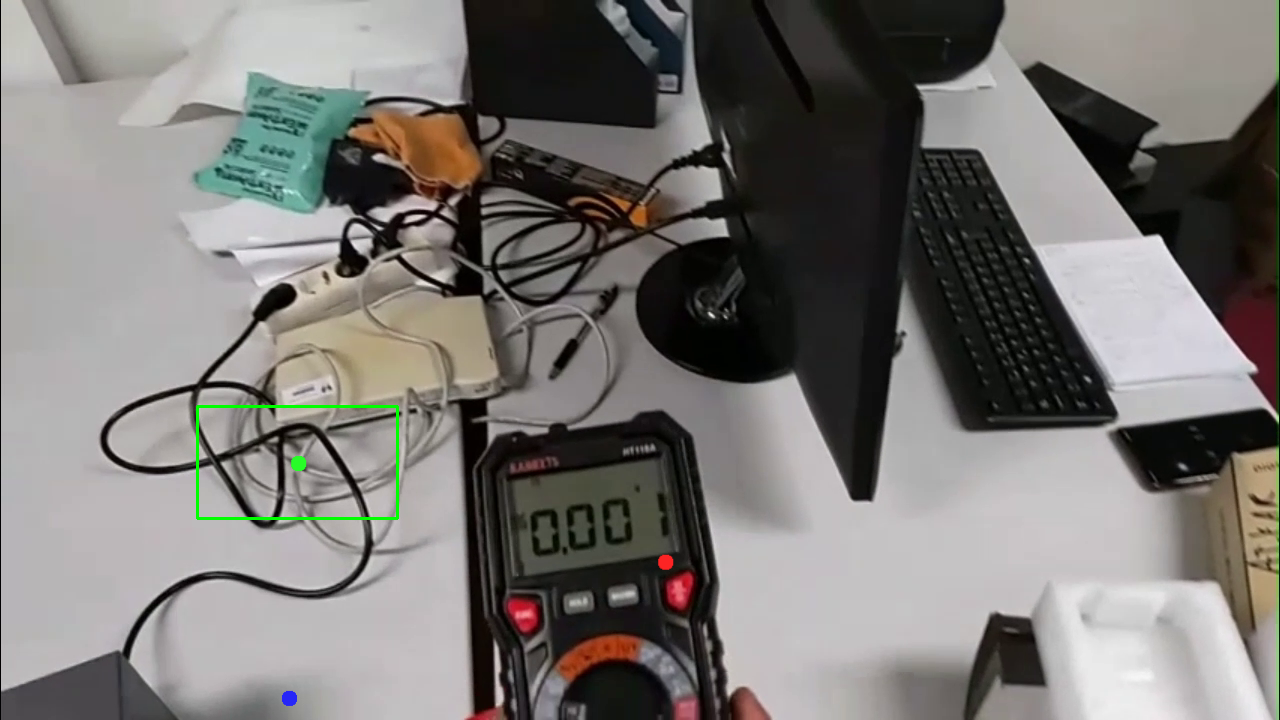

In [47]:
# @title Visualize the bounding boxes

from google.colab.patches import cv2_imshow
import cv2

# Assuming 'video_viz' contains the video frames and 'framez' holds the frame index
framez = 10  # Change this index to the desired frame


box_coords = boxes_in_frame[framez]  # Access the bounding box coordinates for the selected frame
# Assuming 'specific_frame' holds the frame to visualize the bounding box
# You can retrieve the specific frame from 'video_viz' using the frame index
specific_frame = video_viz[framez].copy()  # Make a copy to avoid modifying the original frame

# Retrieve box coordinates in YOLOv7 format
box_x, box_y, box_width, box_height = box_coords

# Convert coordinates from YOLOv7 to pixel coordinates
height, width, _ = specific_frame.shape
x1 = int((box_x - box_width / 2) * width)
y1 = int((box_y - box_height / 2) * height)
x2 = int((box_x + box_width / 2) * width)
y2 = int((box_y + box_height / 2) * height)

# Draw the bounding box on the frame with the corrected color
cv2.rectangle(specific_frame, (x1, y1), (x2, y2), (0, 255, 0), 2)  # Red rectangle with thickness 2 in BGR format

# Convert the frame to RGB for correct visualization
specific_frame_rgb = cv2.cvtColor(specific_frame, cv2.COLOR_BGR2RGB)

# Display the frame with the corrected bounding box using cv2_imshow
cv2_imshow(specific_frame_rgb)



In [ ]:
print("Tracks:")
print(normalized_points_center)

In [ ]:
# @title Visualization of the all bounding boxes (Don't work propely anymore)

import cv2
import numpy as np
from google.colab.patches import cv2_imshow  # Import cv2_imshow function for Colab

# Assuming 'image_data' and 'bounding_boxes_yolo' are available

# Define a function to draw bounding boxes on the resized image
def draw_boxes(image, boxes):
    img_copy = np.copy(image)  # Create a copy of the resized image

    for box in boxes:
        # Convert YOLOv7 format back to pixel coordinates based on the resized image dimensions
        center_x = int(box[0] * new_width)
        center_y = int(box[1] * new_height)
        box_width = int(box[2] * new_width)
        box_height = int(box[3] * new_height)

        # Calculate box coordinates
        top_left = (center_x - box_width // 2, center_y - box_height // 2)
        bottom_right = (center_x + box_width // 2, center_y + box_height // 2)

        # Draw bounding box on the image
        box_color = (0, 255, 0)  # Green color
        box_thickness = 2
        cv2.rectangle(img_copy, top_left, bottom_right, box_color, box_thickness)

    return img_copy

# Define the new dimensions for displaying the image
new_width = int(image_data.shape[1] * 2)
new_height = int(image_data.shape[0] * 2)
resized_image = cv2.resize(image_data, (new_width, new_height))

# Display images with bounding boxes
for frame_idx, boxes_in_frame in enumerate(bounding_boxes_yolo):
    img_with_boxes = draw_boxes(resized_image, boxes_in_frame)
    cv2_imshow(img_with_boxes)



In [ ]:
# @title Get points from images a grid

import cv2  # For reading the image
import numpy as np
from google.colab.patches import cv2_imshow  # Import cv2_imshow function for Colab

# Load your image using OpenCV (or any other library you prefer)
image_path = 'multimeter_img.png'  # Replace with your image path
image_data = cv2.imread(image_path)
image_data = cv2.resize(image_data, (256, 256))




# Define a function to generate multiple points in a grid pattern
def generate_grid_points(image, rows=3, cols=3):
    points = []
    height, width = image.shape[:2]

    for i in range(rows):
        for j in range(cols):
            y = int((i + 1) * height / (rows + 1))
            x = int((j + 1) * width / (cols + 1))
            points.append([0, y, x])

    return np.array(points, dtype=np.int32)

# Use the function to get the center point
center_point = generate_grid_points(image_data)

# Rest of your code that uses center_point
resize_height = 256
resize_width = 256

# Assuming the 'media' module and other functions are defined elsewhere in your code
frames = media.resize_video(video, (resize_height, resize_width))
query_points = center_point

# Visualize query_points
for point in query_points:
    print(f"Query Point: {point}")

######## PROCESSING VIDEO ######### (BEGGING OF THE BLACK BOX)

query_features, _ = online_init_apply(frames=preprocess_frames(frames[None, None, 0]), query_points=query_points[None])
causal_state = construct_initial_causal_state(query_points.shape[0], len(query_features.resolutions) - 1)


# Predict point tracks frame by frame
predictions = []
for i in range(frames.shape[0]):
  (prediction, causal_state), _ = online_predict_apply(
      frames=preprocess_frames(frames[None, None, i]),
      query_features=query_features,
      causal_context=causal_state,
  )
  predictions.append(prediction)

tracks = np.concatenate([x['tracks'][0] for x in predictions], axis=1)
occlusions = np.concatenate([x['occlusion'][0] for x in predictions], axis=1)
expected_dist = np.concatenate([x['expected_dist'][0] for x in predictions], axis=1)

visibles = postprocess_occlusions(occlusions, expected_dist)


########### SHOW RESULTS ########## (FINAL OF THE BLACK BOX)

# Normalizar os pontos para uma faixa de 0 a 1
normalized_points = tracks / np.array([[resize_width, resize_height]])
print("Normalized Points:")
for frame_idx in range(len(normalized_points)):
    points_in_frame = normalized_points[frame_idx]
    #print(f"Frame {frame_idx} - Points: {points_in_frame}") ### Eu comentei esta secção não escrever tudo



# Visualize sparse point tracks
tracks = transforms.convert_grid_coordinates(tracks, (resize_width, resize_height), (width, height))
video_viz = viz_utils.paint_point_track(video, tracks, visibles)
media.show_video(video_viz, fps=10)

In [ ]:
# @title GET resolution

import cv2

# Replace 'path_to_your_video_file.mp4' with the actual path to your video file
video_path = 'test_multimeter.mp4'

# Open the video file
cap = cv2.VideoCapture(video_path)

# Get the resolution (width and height) of the video
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

print(f"Video resolution: {width} x {height}")

# Release the video capture object
cap.release()

Video resolution: 1280 x 720


In [ ]:
# @title Get points from first frame middle


def sample_center_point(height, width):
    center_x = width // 2
    center_y = height // 1.2
    center_t = 0  # Considering the first frame
    center_point = np.array([[center_t, center_y, center_x]], dtype=np.int32)
    return center_point


resize_height = 256
resize_width = 256

frames = media.resize_video(video, (resize_height, resize_width))
query_points = sample_center_point(frames.shape[1], frames.shape[2])



query_features, _ = online_init_apply(frames=preprocess_frames(frames[None, None, 0]), query_points=query_points[None])
causal_state = construct_initial_causal_state(query_points.shape[0], len(query_features.resolutions) - 1)


# Predict point tracks frame by frame
predictions = []
for i in range(frames.shape[0]):
  (prediction, causal_state), _ = online_predict_apply(
      frames=preprocess_frames(frames[None, None, i]),
      query_features=query_features,
      causal_context=causal_state,
  )
  predictions.append(prediction)

tracks = np.concatenate([x['tracks'][0] for x in predictions], axis=1)
occlusions = np.concatenate([x['occlusion'][0] for x in predictions], axis=1)
expected_dist = np.concatenate([x['expected_dist'][0] for x in predictions], axis=1)

visibles = postprocess_occlusions(occlusions, expected_dist)

# Visualize sparse point tracks
tracks = transforms.convert_grid_coordinates(tracks, (resize_width, resize_height), (width, height))
video_viz = viz_utils.paint_point_track(video, tracks, visibles)
media.show_video(video_viz, fps=10)


In [ ]:
# @title Progressively Predict Sparse Point Tracks - RANDOM   {form-width: "25%"}

resize_height = 256  # @param {type: "integer"}
resize_width = 256  # @param {type: "integer"}
num_points = 1  # @param {type: "integer"}

frames = media.resize_video(video, (resize_height, resize_width))
query_points = sample_random_points(0, frames.shape[1], frames.shape[2], num_points)

query_features, _ = online_init_apply(frames=preprocess_frames(frames[None, None, 0]), query_points=query_points[None])
causal_state = construct_initial_causal_state(query_points.shape[0], len(query_features.resolutions) - 1)


# Predict point tracks frame by frame
predictions = []
for i in range(frames.shape[0]):
  (prediction, causal_state), _ = online_predict_apply(
      frames=preprocess_frames(frames[None, None, i]),
      query_features=query_features,
      causal_context=causal_state,
  )
  predictions.append(prediction)

tracks = np.concatenate([x['tracks'][0] for x in predictions], axis=1)
occlusions = np.concatenate([x['occlusion'][0] for x in predictions], axis=1)
expected_dist = np.concatenate([x['expected_dist'][0] for x in predictions], axis=1)

visibles = postprocess_occlusions(occlusions, expected_dist)

# Visualize sparse point tracks
tracks = transforms.convert_grid_coordinates(tracks, (resize_width, resize_height), (width, height))
video_viz = viz_utils.paint_point_track(video, tracks, visibles)
media.show_video(video_viz, fps=10)

In [ ]:
# @title Select Any Points at First Frame {form-width: "25%"}

# Generate a colormap with 20 points, no need to change unless select more than 20 points
colormap = viz_utils.get_colors(20)

fig, ax = plt.subplots(figsize=(10, 5))
ax.imshow(video[0])
ax.axis('off')
ax.set_title('You can select more than 1 points. After select enough points, run the next cell.')

select_points = []

 # Event handler for mouse clicks
def on_click(event):
  if event.button == 1 and event.inaxes == ax:  # Left mouse button clicked
    x, y = int(np.round(event.xdata)), int(np.round(event.ydata))

    select_points.append(np.array([x, y]))

    color = colormap[len(select_points) - 1]
    color = tuple(np.array(color) / 255.0)
    ax.plot(x, y, 'o', color=color, markersize=5)
    plt.draw()

fig.canvas.mpl_connect('button_press_event', on_click)
plt.show()

In [ ]:
# @title Predict Point Tracks for the Selected Points {form-width: "25%"}

resize_height = 256  # @param {type: "integer"}
resize_width = 256  # @param {type: "integer"}

def convert_select_points_to_query_points(frame, points):
  """Convert select points to query points.

  Args:
    points: [num_points, 2], [t, y, x]
  Returns:
    query_points: [num_points, 3], [t, y, x]
  """
  points = np.stack(points)
  query_points = np.zeros(shape=(points.shape[0], 3), dtype=np.float32)
  query_points[:, 0] = frame
  query_points[:, 1] = points[:, 1]
  query_points[:, 2] = points[:, 0]
  return query_points

frames = media.resize_video(video, (resize_height, resize_width))
query_points = convert_select_points_to_query_points(0, select_points)
query_points = transforms.convert_grid_coordinates(
    query_points, (1, height, width), (1, resize_height, resize_width), coordinate_format='tyx')

query_features, _ = online_init_apply(frames=preprocess_frames(frames[None, None, 0]), query_points=query_points[None])
causal_state = construct_initial_causal_state(query_points.shape[0], len(query_features.resolutions) - 1)

# Predict point tracks frame by frame
predictions = []
for i in tqdm(range(frames.shape[0])):
  (prediction, causal_state), _ = online_predict_apply(
      frames=preprocess_frames(frames[None, None, i]),
      query_features=query_features,
      causal_context=causal_state,
  )
  predictions.append(prediction)

tracks = np.concatenate([x['tracks'][0] for x in predictions], axis=1)
occlusions = np.concatenate([x['occlusion'][0] for x in predictions], axis=1)
expected_dist = np.concatenate([x['expected_dist'][0] for x in predictions], axis=1)

visibles = postprocess_occlusions(occlusions, expected_dist)

# Visualize sparse point tracks
tracks = transforms.convert_grid_coordinates(tracks, (resize_width, resize_height), (width, height))
video_viz = viz_utils.paint_point_track(video, tracks, visibles, colormap)
media.show_video(video_viz, fps=20)

In [74]:
# @title Donwload a Video

import imageio

# Defina a localização do arquivo de saída
output_path = 'output_video.mp4'

# Salve o vídeo usando imageio
# Certifique-se de 'video_viz' ser um array numpy válido representando o vídeo
imageio.mimsave(output_path, video_viz)

# Baixe o vídeo
files.download(output_path)



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

That's all Folks!